In [193]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
import joblib

In [194]:

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("toyota_parcial")

<Experiment: artifact_location='mlflow-artifacts:/576424483513881687', creation_time=1747861702848, experiment_id='576424483513881687', last_update_time=1747861702848, lifecycle_stage='active', name='toyota_parcial', tags={}>

In [195]:
# Cargar dataset
df = pd.read_csv(
    "https://raw.githubusercontent.com/dodobeatle/dataeng-datos/refs/heads/main/ToyotaCorolla.csv",
    encoding="utf8",
    engine="python"
)

In [ ]:
# 2. Separar X (todas las columnas salvo Price) e y (Price)
X = df.drop("Price", axis=1)
y = df["Price"]

# Aqui sacamos las columnas que no nos interesan
X = df.drop(["Price", "Model", "Cylinders", "Id", "Radio_cassette", "BOVAG_Guarantee"
             ,"Backseat_Divider", "Mfg_Month","Mfg_Year", "Automatic", "Central_Lock",
             "Met_Color", "Mfr_Guarantee", "Guarantee_Period", "Gears", "Radio", "Power_Steering",
             "Metallic_Rim", "Tow_Bar", "Sport_Model"], axis=1)


# Price es el target
# Cylinders no son relevantes para el modelo al ser constante
# Model lo sacamos de momento, aunque luego lo podemos usar para el modelo final

# COMBINAR AIRBAGS
X["Airbag_Count"] = df["Airbag_1"].fillna(0) + df["Airbag_2"].fillna(0)
X.drop(["Airbag_1", "Airbag_2"], axis=1, inplace=True)

# Preprocesamiento
X = pd.get_dummies(X, drop_first=True)           # One-hot encoding
X = X.apply(pd.to_numeric, errors='coerce')      # Forzar datos a numérico
y = pd.to_numeric(y, errors='coerce')            # Lo mismo para el target

# Combinar X e y para eliminar filas con NaNs
combined = pd.concat([X, y], axis=1).dropna()
X = combined.drop("Price", axis=1)
y = combined["Price"]

# Convertir a float y agregar constante para OLS
X = X.astype(float)
y = y.astype(float)
X = sm.add_constant(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1
)


In [197]:
# Lasso Regression
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Quitamos la constante para Lasso (no la necesita)
X_train_lasso = X_train.drop("const", axis=1)
X_test_lasso  = X_test.drop("const", axis=1)

lasso = LassoCV(cv=5, random_state=1)
lasso.fit(X_train_lasso, y_train)

y_pred_lasso = lasso.predict(X_test_lasso)

# Métricas
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
mae_lasso  = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso   = r2_score(y_test, y_pred_lasso)

print("Lasso RMSE:", rmse_lasso)
print("Lasso MAE: ", mae_lasso)
print("Lasso R2:  ", r2_lasso)

# Importancia de features
lasso_features = X_train_lasso.columns[lasso.coef_ != 0]
print("Features seleccionadas por Lasso:", lasso_features.tolist())




Lasso RMSE: 3910.746720391878
Lasso MAE:  2142.131645062006
Lasso R2:   -0.24819105315098056
Features seleccionadas por Lasso: ['KM', 'cc', 'Weight']


In [198]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Estandarizar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_lasso)
X_test_scaled = scaler.transform(X_test_lasso)

# PCA: elegir número de componentes que expliquen >95% varianza
pca = PCA(n_components=0.95, random_state=1)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Número de componentes seleccionados por PCA:", pca.n_components_)

# Puedes entrenar un modelo con los componentes principales
lasso_pca = LassoCV(cv=5, random_state=1)
lasso_pca.fit(X_train_pca, y_train)
y_pred_pca = lasso_pca.predict(X_test_pca)

rmse_pca = np.sqrt(mean_squared_error(y_test, y_pred_pca))
print("Lasso+PCA RMSE:", rmse_pca)
print("Lasso+PCA R2:", r2_score(y_test, y_pred_pca))

Número de componentes seleccionados por PCA: 13
Lasso+PCA RMSE: 1331.8224292972884
Lasso+PCA R2: 0.8552380798801404


In [199]:
# # Recalculate OLS metrics using y_test and y_pred from cell 10
# # Make sure cell 10 has been executed so y_pred is defined

# rmse_ols = root_mean_squared_error(y_test, y_pred)
# mae_ols = mean_absolute_error(y_test, y_pred)
# r2_ols = r2_score(y_test, y_pred)

# results = pd.DataFrame({
#     "Modelo": ["OLS", "Lasso", "Lasso+PCA"],
#     "RMSE": [rmse_ols, rmse_lasso, rmse_pca],
#     "MAE": [mae_ols, mae_lasso, mean_absolute_error(y_test, y_pred_pca)],
#     "R2": [r2_ols, r2_lasso, r2_score(y_test, y_pred_pca)]
# })
# print(results)

In [200]:
def detect_outliers(X):
    cols = list(X)
    outliers = pd.DataFrame(columns = ['Feature', 'Number of Outliers'])
    for column in cols:
        if column in df.select_dtypes(include=np.number).columns:
            q1 = df[column].quantile(0.25)
            q3 = df[column].quantile(0.75)
            iqr = q3 - q1
            fence_low = q1 - (1.5*iqr)
            fence_high = q3 + (1.5*iqr)
            outliers = pd.concat([outliers, pd.DataFrame({'Feature':[column], 'Number of Outliers':[df.loc[(df[column] < fence_low) | (df[column] > fence_high)].shape[0]]})], ignore_index=True)
    return outliers

detect_outliers(X)

,Feature,Number of Outliers
0,Age_08_04,7
1,KM,49
2,HP,11
3,cc,123
4,Doors,0
5,Quarterly_Tax,224
6,Weight,66
7,ABS,268
8,Airco,0
9,Automatic_airco,81


In [201]:

def find_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    """
    Identifica filas duplicadas completas en el DataFrame.

    Parámetros
    ----------
    df : pd.DataFrame
        El DataFrame en el que buscar duplicados.

    Devuelve
    -------
    pd.DataFrame
        Un DataFrame con todas las filas duplicadas (sin incluir la primera aparición).
    """
    # mask de duplicados (True en segundas y sucesivas apariciones)
    mask = df.duplicated(keep='first')
    # DataFrame con las filas duplicadas
    duplicates = df[mask].copy()
    return duplicates


duplicates = find_duplicates(df)
print(f"Número de filas duplicadas: {len(duplicates)}")
print("Filas duplicadas:")
print(duplicates)


Número de filas duplicadas: 0
Filas duplicadas:
Empty DataFrame
Columns: [Id, Model, Price, Age_08_04, Mfg_Month, Mfg_Year, KM, Fuel_Type, HP, Met_Color, Automatic, cc, Doors, Cylinders, Gears, Quarterly_Tax, Weight, Mfr_Guarantee, BOVAG_Guarantee, Guarantee_Period, ABS, Airbag_1, Airbag_2, Airco, Automatic_airco, Boardcomputer, CD_Player, Central_Lock, Powered_Windows, Power_Steering, Radio, Mistlamps, Sport_Model, Backseat_Divider, Metallic_Rim, Radio_cassette, Tow_Bar]
Index: []

[0 rows x 37 columns]


In [202]:
#hasta no tener menos de 16 features no se puede mostrar esto satisfactoriamente

# # Create a figure for multiple boxplots
# plt.figure(figsize=(15, 10))

# # Loop through each column in the boston dataframe
# for i, column in enumerate(df.columns):
#     plt.subplot(4, 4, i+1)  # Adjust grid size based on number of columns
#     sns.boxplot(y=df[column])
#     plt.title(f'Boxplot of {column}')
#     plt.tight_layout()

# plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Add spacing between subplots
# plt.suptitle('Boxplots for All Features', fontsize=16, y=1.02)
# plt.tight_layout()

In [203]:
with mlflow.start_run(run_name="ols_model_run"):
    # 9. Ajuste OLS
    model   = sm.OLS(y_train, X_train)
    results = model.fit()

    # 10. Predicción
    y_pred = results.predict(X_test)

    from sklearn.metrics import root_mean_squared_error


    # 11. Métricas
    rmse       = root_mean_squared_error(y_test, y_pred)
    mae        = mean_absolute_error(y_test, y_pred)
    r2_sklearn = r2_score(y_test, y_pred)
    r2_sm      = results.rsquared
    adj_r2     = results.rsquared_adj
    aic        = results.aic
    bic        = results.bic

    # Logging de métricas a MLflow (asegúrate que sean float)
    mlflow.log_metric("rmse", float(rmse))
    mlflow.log_metric("mae", float(mae))
    mlflow.log_metric("r2_sklearn", float(r2_sklearn))
    mlflow.log_metric("r2_statsmodels", float(r2_sm))
    mlflow.log_metric("adj_r2", float(adj_r2))
    mlflow.log_metric("aic", float(aic))
    mlflow.log_metric("bic", float(bic))
    mlflow.log_metric("n_features", int(X_train.shape[1]))
    

    # 12. Carpeta de artefactos
    os.makedirs("mlartifacts", exist_ok=True)

    # 15. Summary de OLS
    summary_path = os.path.join("mlartifacts", "ols_summary.txt")
    with open(summary_path, "w") as f:
        f.write(results.summary().as_text())
    mlflow.log_artifact(summary_path)

    # 16. Serializar modelo
    model_pkl = os.path.join("mlartifacts", "ols_model.pkl")
    joblib.dump(results, model_pkl)
    mlflow.log_artifact(model_pkl)

    # Guardar nombres de features
    features_path = os.path.join("mlartifacts", "features.txt")
    with open(features_path, "w") as f:
        f.write("\n".join(X.columns))
    mlflow.log_artifact(features_path)

    # =======================
    # VIF ANALYSIS
    # =======================

    vif_data = pd.DataFrame()
    vif_data["feature"] = X_train.columns
    vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

    vif_path = os.path.join("mlartifacts", "vif_report.csv")
    vif_data.to_csv(vif_path, index=False)
    mlflow.log_artifact(vif_path)

    # =======================
    # GRÁFICOS
    # =======================

    # Plot: Real vs. Predicho
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title("Actual vs. Predicted Price")
    plt.grid(True)
    real_vs_pred_path = os.path.join("mlartifacts", "actual_vs_predicted.png")
    plt.savefig(real_vs_pred_path)
    mlflow.log_artifact(real_vs_pred_path)
    plt.close()

    # Plot: Residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Predicted Price")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.grid(True)
    residuals_path = os.path.join("mlartifacts", "residuals_plot.png")
    plt.savefig(residuals_path)
    mlflow.log_artifact(residuals_path)
    plt.close()

    # =======================
    # MATRIZ DE CORRELACIÓN
    # =======================

    plt.figure(figsize=(16, 12))
    corr_matrix = pd.concat([X_train, y_train], axis=1).corr()
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        cbar_kws={"shrink": 0.75},
        linewidths=0.5,
        annot_kws={"size": 10}
    )
    plt.title("Correlation Matrix", fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)

    corr_matrix_path = os.path.join("mlartifacts", "correlation_matrix.png")
    plt.tight_layout()
    plt.savefig(corr_matrix_path)
    mlflow.log_artifact(corr_matrix_path)
    plt.close()

    # # =======================
    # # SCATTER MATRIX (FULL PAIR PLOT)
    # # =======================
    # # Combina X_train y y_train para el pairplot
    # df_pairs = pd.concat([X_train, y_train.rename("target")], axis=1)

    # # Opcional: muestrea hasta 500 filas para no saturar la gráfica
    # df_pairs_sample = df_pairs.sample(n=min(len(df_pairs), 500), random_state=1)

    # # Usa Seaborn PairGrid para trazar cada par de variables
    # g = sns.PairGrid(df_pairs_sample, diag_sharey=False, height=2.5)
    # g.map_upper(sns.scatterplot, s=15, edgecolor="w", alpha=0.6)
    # g.map_lower(sns.scatterplot, s=15, edgecolor="w", alpha=0.6)
    # g.map_diag(sns.histplot, kde=True)
    # plt.suptitle("Scatter Matrix Completa de Features y Target", y=1.02)

    # scatter_matrix_path = os.path.join("mlartifacts", "scatter_matrix.png")
    # g.fig.savefig(scatter_matrix_path)
    # mlflow.log_artifact(scatter_matrix_path)
    # plt.close()
    

    print("Modelo OLS registrado con MLflow.")

Modelo OLS registrado con MLflow.
🏃 View run ols_model_run at: http://localhost:5000/#/experiments/576424483513881687/runs/0306456387434dd2a84b5e67385535a1
🧪 View experiment at: http://localhost:5000/#/experiments/576424483513881687


## 1. Vemos la dimensión del dataset

In [204]:
df.shape

(1436, 37)

## 2. Info general del dataset

In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                1436 non-null   int64 
 1   Model             1436 non-null   object
 2   Price             1436 non-null   int64 
 3   Age_08_04         1436 non-null   int64 
 4   Mfg_Month         1436 non-null   int64 
 5   Mfg_Year          1436 non-null   int64 
 6   KM                1436 non-null   int64 
 7   Fuel_Type         1436 non-null   object
 8   HP                1436 non-null   int64 
 9   Met_Color         1436 non-null   int64 
 10  Automatic         1436 non-null   int64 
 11  cc                1436 non-null   int64 
 12  Doors             1436 non-null   int64 
 13  Cylinders         1436 non-null   int64 
 14  Gears             1436 non-null   int64 
 15  Quarterly_Tax     1436 non-null   int64 
 16  Weight            1436 non-null   int64 
 17  Mfr_Guarantee 

## 3. Descripción del dataset

In [206]:
df.describe()

,Id,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
count,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.00000,...,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000
mean,721.555014,10730.824513,55.947075,5.548747,1999.625348,68533.259749,101.502089,0.674791,0.055710,1576.85585,...,0.580084,0.561978,0.977716,0.146240,0.256964,0.300139,0.770195,0.204735,0.145543,0.277855
std,416.476890,3626.964585,18.599988,3.354085,1.540722,37506.448872,14.981080,0.468616,0.229441,424.38677,...,0.493717,0.496317,0.147657,0.353469,0.437111,0.458478,0.420854,0.403649,0.352770,0.448098
min,1.000000,4350.000000,1.000000,1.000000,1998.000000,1.000000,69.000000,0.000000,0.000000,1300.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,361.750000,8450.000000,44.000000,3.000000,1998.000000,43000.000000,90.000000,0.000000,0.000000,1400.00000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,721.500000,9900.000000,61.000000,5.000000,1999.000000,63389.500000,110.000000,1.000000,0.000000,1600.00000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1081.250000,11950.000000,70.000000,8.000000,2001.000000,87020.750000,110.000000,1.000000,0.000000,1600.00000,...,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1442.000000,32500.000000,80.000000,12.000000,2004.000000,243000.000000,192.000000,1.000000,1.000000,16000.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


C:\Users\Usuario\AppData\Local\Temp\ipykernel_13196\3731943685.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Fuel_Type",palette="pastel")


<Axes: xlabel='Fuel_Type', ylabel='count'>

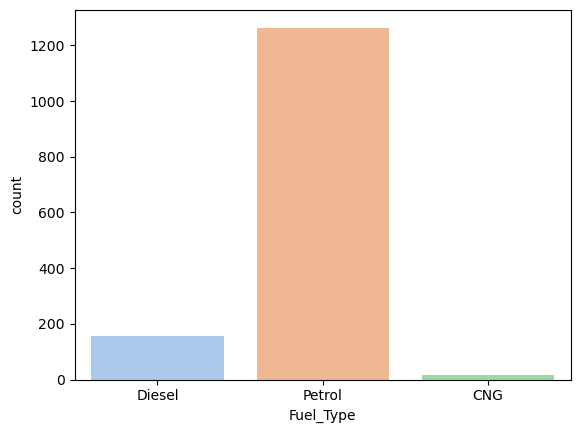

In [207]:
sns.countplot(data=df, x="Fuel_Type",palette="pastel")

In [208]:
print(df.columns.tolist())


['Id', 'Model', 'Price', 'Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'cc', 'Doors', 'Cylinders', 'Gears', 'Quarterly_Tax', 'Weight', 'Mfr_Guarantee', 'BOVAG_Guarantee', 'Guarantee_Period', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock', 'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette', 'Tow_Bar']


In [209]:
df.isnull().sum()

Id                  0
Model               0
Price               0
Age_08_04           0
Mfg_Month           0
Mfg_Year            0
KM                  0
Fuel_Type           0
HP                  0
Met_Color           0
Automatic           0
cc                  0
Doors               0
Cylinders           0
Gears               0
Quarterly_Tax       0
Weight              0
Mfr_Guarantee       0
BOVAG_Guarantee     0
Guarantee_Period    0
ABS                 0
Airbag_1            0
Airbag_2            0
Airco               0
Automatic_airco     0
Boardcomputer       0
CD_Player           0
Central_Lock        0
Powered_Windows     0
Power_Steering      0
Radio               0
Mistlamps           0
Sport_Model         0
Backseat_Divider    0
Metallic_Rim        0
Radio_cassette      0
Tow_Bar             0
dtype: int64

## Análisis univariado

In [210]:
# pass
# #Estilo general,
# sns.set(style="whitegrid")

# #Definir la variable objetivo,
# target = "Price"

# #Columnas numéricas excluyendo la variable objetivo,
# numeric_cols = df.select_dtypes(include=["number"]).columns
# feature_cols = [col for col in numeric_cols if col != target]

# #Graficar por cada feature,
# for col in feature_cols:
#     fig, axs = plt.subplots(2, 3, figsize=(18, 10))
#     fig.suptitle(f"Análisis exploratorio de: {col}", fontsize=16)

#     # (a) Histograma + KDE
#     sns.histplot(data=df, x=col, bins=30, kde=True, ax=axs[0, 0], color="steelblue")
#     axs[0, 0].set(title="Distribución (Histograma + KDE)", xlabel=col, ylabel="Frecuencia")

#     # (b) Boxplot
#     sns.boxplot(data=df, y=col, ax=axs[0, 1], color="lightcoral")
#     axs[0, 1].set(title="Boxplot", xlabel="", ylabel=col)

#     # (c) Violinplot (sin palette, usando color directamente)
#     sns.violinplot(data=df, y=col, ax=axs[0, 2], color="skyblue")
#     axs[0, 2].set(title="Violinplot", xlabel="", ylabel=col)

#     # (d) Densidad (KDE sola)
#     sns.kdeplot(data=df[col].dropna(), ax=axs[1, 0], fill=True, color="purple")
#     axs[1, 0].set(title="Curva de Densidad", xlabel=col, ylabel="Densidad")

#     # (e) Scatterplot vs Price
#     sns.scatterplot(data=df, x=col, y=target, ax=axs[1, 1], alpha=0.6)
#     axs[1, 1].set(title=f"{target} en función de {col}", xlabel=col, ylabel=target)

#     # Espacio vacío para balance visual
#     axs[1, 2].axis("off")

#     # Ajuste final
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     print(col)
#     plt.show()

### Variables mas correlacionadas con price

In [211]:
# 1. Ordenamos por |correlación| absoluta con Price
top_vars = (corr['Price']
            .abs()
            .sort_values(ascending=False)
            .head(11)   # Price + 10 más altas
            .index)

# 2. Filtramos la sub-matriz
sub_corr = corr.loc[top_vars, top_vars]

# 3. Graficamos sólo ese cuadrante
plt.figure(figsize=(10, 8))
sns.heatmap(
    sub_corr,
    cmap="vlag",
    annot=True,
    fmt=".2f",
    linewidths=.5,
    center=0
)
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 correlaciones con Price", fontsize=16)
plt.tight_layout()
plt.show()


NameError: name 'corr' is not defined